# Homework 3 - Attacks and Defenses in Federated Learning
### Tea Pula 23-125-578


## Question 1: Influence of Non-I.I.D. Data in Attacks and Defenses (4 points)

Using the template code from [attacks_and_defenses.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_3/attacks_and_defenses.ipynb), experiment with how non-i.i.d. data distributions influence the performance of attacks and defenses. Utilize the `AttackerGradientReversion` for the attack. Keep all hyperparameters the same as those in the template code, except modify the data distribution among the clients to be non-i.i.d.

### Scoring:
- _(1 point)_ Generate test accuracy for 10 rounds, both when there is no defense and when the defenses are `krum`, `multi_krum`, and `majority_sign`. 
- _(1 point)_ Compile the results of these runs into one plot to visually compare the influence of each defense mechanism under non-i.i.d. conditions.
- _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism. 

In [1]:
from lab.tutorial_1a.hfl_complete import *


class GradWeightClient(Client):
    def __init__(self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: initial_weights - final_weights
        gradients = [initial_weight - final_weight for final_weight, initial_weight in
                     zip(self.model.parameters(), initial_weights)]
        return [gradient.detach().cpu().clone() for gradient in gradients]


class FedAvgGradServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            GradWeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs,
                               self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]

        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            # Other code remains the same until the aggregation part
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                    for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result


class FedAvgServerDefense(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int,
                 seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs,
                               self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            if self.defense_method:
                selected_indices = self.defense_method(client_updates)
            else:
                selected_indices = range(len(client_updates))  # Use all updates if no defense is specified
            print(
                f'The following indices are selected in the training {np.sort(indices_chosen_clients[selected_indices])}')
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients[selected_indices])
            chosen_adjusted_weights = [
                [self.client_sample_counts[indices_chosen_clients[ind]] / chosen_sum_nr_samples * tens for tens in
                 client_updates[ind][1]]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result


class FedAvgServerDefenseCoordinate(FedAvgGradServer):
    def __init__(self, lr: float, batch_size: int, client_subsets: list, client_fraction: float, nr_local_epochs: int,
                 seed: int, defense=None):
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.
        run_result = RunResult(self.name, self.nr_clients, self.client_fraction, self.batch_size, self.nr_local_epochs,
                               self.lr, self.seed)

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                    for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(device=device)  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(self.model.parameters(), server_weights):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        return run_result


def krum(clients_updates, n=20, m=4):
    # Number of neighboring updates to consider
    n_neighbors = n - m - 2
    scores = []

    # Calculate the score for each update
    for i in range(len(clients_updates)):
        distances = []
        for j in range(len(clients_updates)):
            if i != j:
                # Compute squared l2 distance between updates
                distance = sum((param_i - param_j).pow(2).sum()
                               for param_i, param_j in zip(clients_updates[i][1], clients_updates[j][1]))
                distances.append(distance)

        # Get the n_neighbors smallest distances
        nearest_distances = sorted(distances)[:n_neighbors]
        # Sum of these distances is the score of this client's update
        scores.append(sum(nearest_distances))

    # Select the index with the smallest score
    selected_index = scores.index(min(scores))
    return [selected_index]


def multi_krum(clients_updates, k=14, n=20, m=5):
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(k):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(remaining_updates, n - i, m)[0]

        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)

        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)

    return selected_indices


def majority_sign_filter(all_updates):
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))

    # Step 2: Calculate sign and count for determining majority
    all_signs = [torch.sign(torch.stack(parameter_group, dim=0)) for parameter_group in parameter_wise_updates]

    # Step 3: Determine the majority sign for each parameter coordinate
    majority_signs = [torch.sign(torch.sum(signs, dim=0)) for signs in all_signs]

    # Step 4: Filter out gradients whose signs don't match the majority
    filtered_updates = []
    for idx, parameter_group in enumerate(parameter_wise_updates):
        majority_sign = majority_signs[idx]
        zeroed_gradients = []

        for gradient in parameter_group:
            gradient_signs = torch.sign(gradient)
            # Zero out gradients where the sign does not match the majority
            gradient[gradient_signs != majority_sign] = 0
            zeroed_gradients.append(gradient)

        # Step 5: Calculate the average of the filtered gradients
        filtered_average = torch.mean(torch.stack(zeroed_gradients), dim=0)
        filtered_updates.append(filtered_average * 20)

    return filtered_updates


# malicious clients
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5 * w for w in honest_gradients]

        return reversed_gradients

In [2]:
#Baseline
# lr = 0.02, batch_size = 200, sample_split, client_fraction = 0.2, epochs = 2, seed = 42
def run_experiment(dstrb, sample_split, defense=None, no_runs=10, seed=42):
    # hyperparameters remain the same as in the template
    if defense == majority_sign_filter:
        print("inside majority sign filter")
        server = FedAvgServerDefenseCoordinate(
            lr=0.02,
            batch_size=200,
            client_subsets=sample_split,
            client_fraction=0.2,
            nr_local_epochs=2,
            seed=seed,
            defense=defense
        )
    else:
        server = FedAvgServerDefense(
            lr=0.02,
            batch_size=200,
            client_subsets=sample_split,
            client_fraction=0.2,
            nr_local_epochs=2,
            seed=seed,
            defense=defense)

    # inject 20% malicious clients (with AttackerGradientReversion injection)
    clients = server.clients
    num_malicious = int(0.20 * len(clients))
    # Randomly select indices for the clients to undergo gradient inversion attack
    malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)
    print(f"Distribution: {dstrb}, Defense type: {defense}")

    # replace the randomly selected clients with the new malicious instances of AttackerGradientInversion
    for idx in malicious_indices:
        client_data = clients[idx].loader_train.dataset
        lr = clients[idx].optimizer.param_groups[0]['lr']
        batch_size = clients[idx].loader_train.batch_size
        nr_epochs = clients[idx].nr_epochs
        clients[idx] = AttackerGradientReversion(client_data, lr, batch_size, nr_epochs)

    result = server.run(no_runs)
    return result.as_df()

In [3]:
# i.i.d. data
iid_sample_split = split(100, True, 42)

# non-i.i.d. data
non_iid_sample_split = split(100, False, 42)

In [19]:
# running the experiment for iid and non iid data distributions in order to compare

# running for IID data
df_no_defense_iid = run_experiment("IID", iid_sample_split, defense=None)
df_krum_defense_iid = run_experiment("IID", iid_sample_split, defense=krum)
df_multi_krum_defense_iid = run_experiment("IID", iid_sample_split, defense=multi_krum)
df_majority_sign = run_experiment("IID", iid_sample_split, defense=majority_sign_filter)

Distribution: IID, Defense type: None


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 7  8 12 17 36 45 47 49 54 61 63 68 71 73 75 83 84 86 89 94]


Rounds:  10%|█         | 1/10 [00:03<00:27,  3.07s/it]

The following indices are selected in the training [ 4  5 13 15 18 30 34 39 44 47 51 53 58 61 62 69 70 74 79 84]


Rounds:  20%|██        | 2/10 [00:05<00:21,  2.70s/it]

The following indices are selected in the training [ 8 13 23 28 36 37 40 45 54 61 68 69 71 75 76 78 79 86 87 97]


Rounds:  30%|███       | 3/10 [00:08<00:19,  2.85s/it]

The following indices are selected in the training [ 7  8  9 11 20 30 36 40 50 52 53 54 56 59 60 69 75 77 85 94]


Rounds:  40%|████      | 4/10 [00:11<00:18,  3.08s/it]

The following indices are selected in the training [ 2  8 10 15 29 31 35 37 41 45 46 57 65 68 70 73 74 84 87 94]


Rounds:  50%|█████     | 5/10 [00:14<00:13,  2.75s/it]

The following indices are selected in the training [ 7  9 24 25 28 31 41 43 44 62 69 70 73 77 79 81 83 90 93 99]


Rounds:  60%|██████    | 6/10 [00:16<00:09,  2.49s/it]

The following indices are selected in the training [ 3  7  8 12 17 18 26 32 36 39 48 51 53 55 57 58 70 74 89 93]


Rounds:  70%|███████   | 7/10 [00:18<00:07,  2.49s/it]

The following indices are selected in the training [ 5  7 15 24 26 34 39 40 43 44 45 52 54 60 66 77 79 87 91 95]


Rounds:  80%|████████  | 8/10 [00:20<00:04,  2.34s/it]

The following indices are selected in the training [ 3  9 13 20 21 22 23 28 37 54 55 62 67 81 84 85 89 90 92 98]


Rounds:  90%|█████████ | 9/10 [00:23<00:02,  2.36s/it]

The following indices are selected in the training [ 2  3  8 10 13 20 24 30 33 36 45 49 66 76 77 81 83 84 90 98]


Distribution: IID, Defense type: <function krum at 0x3a2829300>


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [63]


Rounds:  10%|█         | 1/10 [00:02<00:20,  2.26s/it]

The following indices are selected in the training [34]


Rounds:  20%|██        | 2/10 [00:04<00:17,  2.19s/it]

The following indices are selected in the training [97]


Rounds:  30%|███       | 3/10 [00:06<00:15,  2.16s/it]

The following indices are selected in the training [30]


Rounds:  40%|████      | 4/10 [00:08<00:13,  2.17s/it]

The following indices are selected in the training [70]


Rounds:  50%|█████     | 5/10 [00:10<00:10,  2.15s/it]

The following indices are selected in the training [70]


Rounds:  60%|██████    | 6/10 [00:13<00:08,  2.18s/it]

The following indices are selected in the training [70]


Rounds:  70%|███████   | 7/10 [00:15<00:06,  2.24s/it]

The following indices are selected in the training [91]


Rounds:  80%|████████  | 8/10 [00:17<00:04,  2.21s/it]

The following indices are selected in the training [62]


Rounds:  90%|█████████ | 9/10 [00:19<00:02,  2.25s/it]

The following indices are selected in the training [81]


Distribution: IID, Defense type: <function multi_krum at 0x3a282b1a0>


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 7 12 17 49 54 61 63 71 75 83 84 86 89 94]


Rounds:  10%|█         | 1/10 [00:03<00:29,  3.31s/it]

The following indices are selected in the training [ 4  5 13 18 30 34 39 44 58 61 62 69 79 84]


Rounds:  20%|██        | 2/10 [00:06<00:26,  3.27s/it]

The following indices are selected in the training [ 8 13 23 37 40 54 61 68 69 75 78 79 87 97]


Rounds:  30%|███       | 3/10 [00:09<00:22,  3.28s/it]

The following indices are selected in the training [ 7  8  9 11 20 30 40 50 52 53 54 56 69 77]


Rounds:  40%|████      | 4/10 [00:13<00:19,  3.28s/it]

The following indices are selected in the training [ 2  8 10 15 29 35 37 57 65 68 74 84 87 94]


Rounds:  50%|█████     | 5/10 [00:16<00:16,  3.34s/it]

The following indices are selected in the training [ 7  9 24 43 44 62 70 77 79 81 83 90 93 99]


Rounds:  60%|██████    | 6/10 [00:19<00:13,  3.35s/it]

The following indices are selected in the training [ 3 12 26 32 39 48 51 53 55 57 58 74 89 93]


Rounds:  70%|███████   | 7/10 [00:23<00:10,  3.42s/it]

The following indices are selected in the training [ 5 26 34 39 40 43 45 52 54 77 79 87 91 95]


Rounds:  80%|████████  | 8/10 [00:26<00:06,  3.39s/it]

The following indices are selected in the training [ 3  9 13 20 22 23 37 54 55 81 84 85 89 90]


Rounds:  90%|█████████ | 9/10 [00:30<00:03,  3.51s/it]

The following indices are selected in the training [ 2  3  8 10 13 20 30 33 77 81 83 84 90 98]


inside majority sign filter
Distribution: IID, Defense type: <function majority_sign_filter at 0x3a285a5c0>


In [24]:
# running for non-IID data
df_no_defense_non_iid = run_experiment("Non IID", non_iid_sample_split, defense=None)
df_krum_defense_non_iid = run_experiment("Non IID", non_iid_sample_split, defense=krum)
df_multi_krum_defense_non_iid = run_experiment("Non IID", non_iid_sample_split, defense=multi_krum)
df_majority_sign_non_iid = run_experiment("Non IID", non_iid_sample_split, defense=majority_sign_filter)

Distribution: Non IID, Defense type: None


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 7  8 12 17 36 45 47 49 54 61 63 68 71 73 75 83 84 86 89 94]


Rounds:  10%|█         | 1/10 [00:02<00:26,  2.91s/it]

The following indices are selected in the training [ 4  5 13 15 18 30 34 39 44 47 51 53 58 61 62 69 70 74 79 84]


Rounds:  20%|██        | 2/10 [00:05<00:19,  2.46s/it]

The following indices are selected in the training [ 8 13 23 28 36 37 40 45 54 61 68 69 71 75 76 78 79 86 87 97]


Rounds:  30%|███       | 3/10 [00:07<00:16,  2.29s/it]

The following indices are selected in the training [ 7  8  9 11 20 30 36 40 50 52 53 54 56 59 60 69 75 77 85 94]


Rounds:  40%|████      | 4/10 [00:09<00:13,  2.26s/it]

The following indices are selected in the training [ 2  8 10 15 29 31 35 37 41 45 46 57 65 68 70 73 74 84 87 94]


Rounds:  50%|█████     | 5/10 [00:11<00:10,  2.19s/it]

The following indices are selected in the training [ 7  9 24 25 28 31 41 43 44 62 69 70 73 77 79 81 83 90 93 99]


Rounds:  60%|██████    | 6/10 [00:13<00:08,  2.13s/it]

The following indices are selected in the training [ 3  7  8 12 17 18 26 32 36 39 48 51 53 55 57 58 70 74 89 93]


Rounds:  70%|███████   | 7/10 [00:15<00:06,  2.18s/it]

The following indices are selected in the training [ 5  7 15 24 26 34 39 40 43 44 45 52 54 60 66 77 79 87 91 95]


Rounds:  80%|████████  | 8/10 [00:17<00:04,  2.14s/it]

The following indices are selected in the training [ 3  9 13 20 21 22 23 28 37 54 55 62 67 81 84 85 89 90 92 98]


Rounds:  90%|█████████ | 9/10 [00:20<00:02,  2.18s/it]

The following indices are selected in the training [ 2  3  8 10 13 20 24 30 33 36 45 49 66 76 77 81 83 84 90 98]


Distribution: Non IID, Defense type: <function krum at 0x3a2829300>


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [73]


Rounds:  10%|█         | 1/10 [00:02<00:20,  2.22s/it]

The following indices are selected in the training [62]


Rounds:  20%|██        | 2/10 [00:04<00:17,  2.15s/it]

The following indices are selected in the training [28]


Rounds:  30%|███       | 3/10 [00:06<00:14,  2.14s/it]

The following indices are selected in the training [40]


Rounds:  40%|████      | 4/10 [00:08<00:13,  2.19s/it]

The following indices are selected in the training [70]


Rounds:  50%|█████     | 5/10 [00:10<00:10,  2.18s/it]

The following indices are selected in the training [73]


Rounds:  60%|██████    | 6/10 [00:13<00:08,  2.17s/it]

The following indices are selected in the training [39]


Rounds:  70%|███████   | 7/10 [00:15<00:06,  2.29s/it]

The following indices are selected in the training [40]


Rounds:  80%|████████  | 8/10 [00:17<00:04,  2.27s/it]

The following indices are selected in the training [22]


Rounds:  90%|█████████ | 9/10 [00:20<00:02,  2.43s/it]

The following indices are selected in the training [3]


Distribution: Non IID, Defense type: <function multi_krum at 0x3a282b1a0>


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

The following indices are selected in the training [ 7 12 17 45 47 49 54 61 63 68 71 75 83 94]


Rounds:  10%|█         | 1/10 [00:03<00:35,  3.89s/it]

The following indices are selected in the training [ 4  5 13 15 30 34 39 44 51 58 61 62 70 79]


Rounds:  20%|██        | 2/10 [00:08<00:32,  4.12s/it]

The following indices are selected in the training [ 8 13 23 40 45 54 61 68 71 76 79 86 87 97]


Rounds:  30%|███       | 3/10 [00:12<00:28,  4.10s/it]

The following indices are selected in the training [ 7  8  9 11 20 30 40 50 52 54 56 60 77 94]


Rounds:  40%|████      | 4/10 [00:16<00:24,  4.02s/it]

The following indices are selected in the training [ 2 10 15 29 31 35 37 45 46 65 68 70 87 94]


Rounds:  50%|█████     | 5/10 [00:19<00:19,  3.96s/it]

The following indices are selected in the training [ 7  9 25 31 43 44 62 69 70 77 79 81 90 93]


Rounds:  60%|██████    | 6/10 [00:23<00:15,  3.83s/it]

The following indices are selected in the training [ 7 12 17 26 32 36 39 48 51 55 58 70 74 93]


Rounds:  70%|███████   | 7/10 [00:27<00:11,  3.86s/it]

The following indices are selected in the training [ 5  7 24 26 39 40 43 44 52 54 79 87 91 95]


Rounds:  80%|████████  | 8/10 [00:31<00:07,  3.80s/it]

The following indices are selected in the training [ 9 13 20 21 22 23 37 54 55 67 81 85 89 90]


Rounds:  90%|█████████ | 9/10 [00:34<00:03,  3.80s/it]

The following indices are selected in the training [ 2 13 20 24 33 45 49 66 76 77 81 83 90 98]


inside majority sign filter
Distribution: Non IID, Defense type: <function majority_sign_filter at 0x3a285a5c0>


In [21]:
import matplotlib.pyplot as plt


def plot_defense_comparison(df_list, labels, title, ylabel="Test Accuracy (%)"):
    plt.figure(figsize=(10, 6))

    for df, label in zip(df_list, labels):
        x = df['Round'] if 'Round' in df.columns else range(1, len(df) + 1)
        y = df['Test accuracy']
        plt.plot(x, y, label=label, marker='o')

    plt.xlabel("Round")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

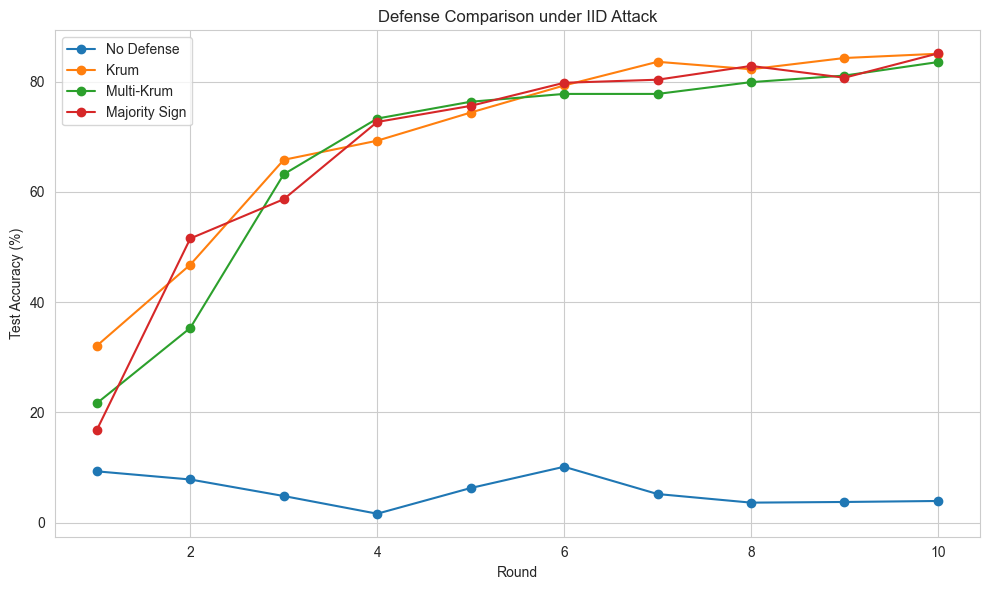

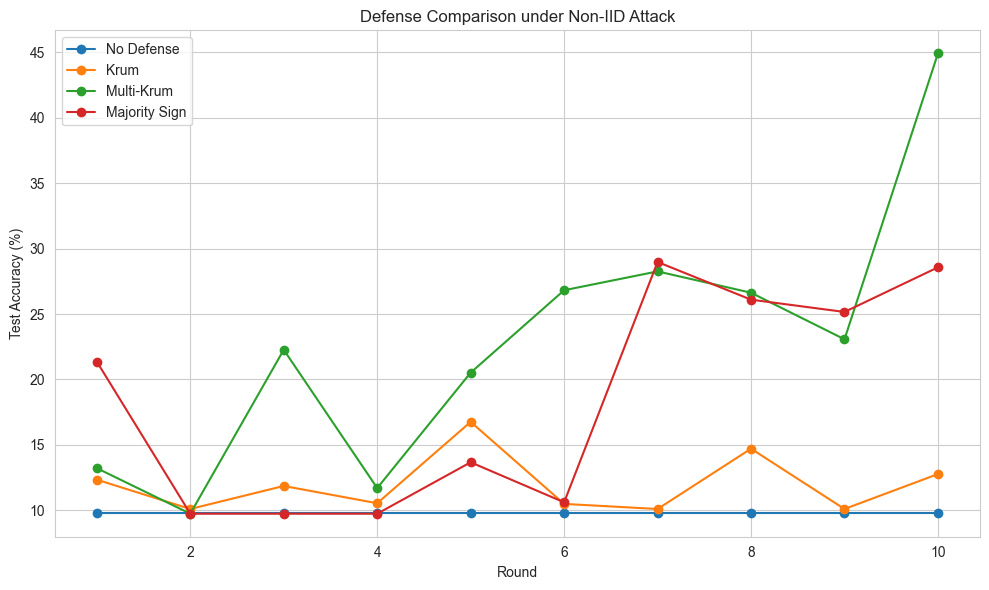

In [37]:
# plot iid
plot_defense_comparison(
    [
        df_no_defense_iid,
        df_krum_defense_iid,
        df_multi_krum_defense_iid,
        df_majority_sign
    ],
    labels=["No Defense", "Krum", "Multi-Krum", "Majority Sign"],
    title="Defense Comparison under IID Attack"
)

# plot non-iid
plot_defense_comparison(
    [
        df_no_defense_non_iid,
        df_krum_defense_non_iid,
        df_multi_krum_defense_non_iid,
        df_majority_sign_non_iid
    ],
    labels=["No Defense", "Krum", "Multi-Krum", "Majority Sign"],
    title="Defense Comparison under Non-IID Attack"
)

- _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism.

Looking at the IID results, we can clearly see that adding defense mechanisms like Krum, Multi-Krum, and Majority Sign to protect against the Gradient Reversion Attack leads to a stable and significant increase in accuracy. All three defenses perform quite similarly and steadily converge to high accuracy values.

But in the non-IID setting, things change drastically. The plot becomes wobbly and unstable, and the overall performance drops. As expected, the no-defense setup performs poorly due to the attack. When we add defenses, the differences between them become more noticeable. Krum performs only slightly better than no defense — in fact, at some rounds, their curves even overlap. Majority Sign is very unstable in the first half of training but picks up a bit in the later rounds (especially from round 7 onward). The defense that stands out the most is Multi-Krum, which manages to maintain relatively better accuracy despite the non-IID data.

This big shift happens because, in a non-IID setting, each client's data comes from a different distribution. That makes the local models more divergent and aggregation more challenging. It also becomes harder to tell which updates are malicious and which are just different due to the data. So, while these defenses work quite well in IID scenarios, their effectiveness drops under non-IID conditions — some more than others.

In [38]:
# save individual defense results just in case
df_no_defense_non_iid.to_csv("no_defense_non_iid.csv", index=False)
df_krum_defense_non_iid.to_csv("krum_defense_non_iid.csv", index=False)
df_multi_krum_defense_non_iid.to_csv("multi_krum_defense_non_iid.csv", index=False)
df_majority_sign_non_iid.to_csv("majority_sign_defense_non_iid.csv", index=False)


## Question 2: Implementing Bulyan Defense (5 points)

[Bulyan defense](https://arxiv.org/abs/1802.07927) combines aspects of `multi-krum` and `trimmed-mean` to protect against sophisticated attacks in federated environments. In this question, you will implement Bulyan by modifying and combining the existing code in the [attacks_and_defenses.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_3/attacks_and_defenses.ipynb).

### Scoring:
- _(1 point)_ Modify the server-side code to integrate a two-step defense process where:
  1. A client-wise defense like `multi-krum` filters out suspicious gradients based on their distance metrics.
  2. A coordinate-wise defense like `trimmed-mean` calculates the mean across the remaining gradients after trimming the extremes.
  
- _(1 point)_ Successfully integrate these two defense mechanisms [`multi-krum`, `trimmed-mean`] to implement the Bulyan.
- _(3 points)_ Evaluate the performance of your implemented Bulyan defense against three types of attacks: `AttackerGradientReversion`, `AttackerPartGradientReversion`, and `AttackerBackdoor`. Vary the defense hyperparameters to make your defense defend against these attacks while keeping the data distribution i.i.d. and the attacker's hyperparameters constant as per the template. Document the performance of your defense strategy against these attacks in your notebook.


In [35]:
import random
# a new data class that help us to process batch
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)

    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)


class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(
                batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None):
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None):
        raise NotImplemented


class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor([
        [1., 0., 1.],
        [-10., 1., -10.],
        [-10., -10., 0.],
        [-10., 1., -10.],
        [1., 0., 1.]
    ])
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)

    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or \
                y_bot >= self.input_shape[2]:
            raise ValueError(f'Position of backdoor outside image limits:'
                             f'image: {self.input_shape}, but backdoor'
                             f'ends at ({x_bot}, {y_bot})')

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device)  # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device)  # )(-52.5678, 2.7537)

    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * \
                                        batch.inputs[:attack_portion] + \
                                        mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask
    
class AttackerBackdoor(GradWeightClient):
    def train_epoch(self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(batch, test=False, attack=True)
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [2 * (initial_weight - final_weight) for final_weight, initial_weight in
                     zip(self.model.parameters(), initial_weights)]

        return [gradient.detach().cpu().clone() for gradient in gradients]

class AttackerPartGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Set random seed for reproducibility
        torch.manual_seed(seed)

        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Flatten the gradients and calculate 10% of the total number of gradient elements
        all_gradients = torch.cat([g.flatten() for g in honest_gradients])
        num_to_manipulate = int(all_gradients.numel())

        # Determine the threshold of parameters to modify
        param_threshold = num_to_manipulate * 0.00001  # Set this to your desired threshold

        # Select the first k layers until the cumulative number of parameters exceeds the threshold
        cumulative_params = 0
        selected_gradients = []
        for gradient in honest_gradients:
            #print(gradient.numel())
            cumulative_params += gradient.numel()
            selected_gradients.append(gradient)
            if cumulative_params >= param_threshold:
                break

        # Multiply the selected gradients by -1000
        for gradient in selected_gradients:
            gradient *= -1000

        return honest_gradients  # Return the modified gradients
    
def tr_mean(all_updates, beta=0.4):
    # 'n_attackers' is the number of top and bottom values to exclude from the mean calculation.

    # Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))
    n_attackers = int(20 * beta)
    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        # Stack gradients to create a new dimension corresponding to clients
        stacked_updates = torch.stack(parameter_group, dim=0)

        # Sort updates along the client dimension
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        # Compute mean excluding the top and bottom 'n_attackers' updates
        if n_attackers > 0:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates

        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient * 20)

    return trimmed_mean_gradients


In [68]:
def bulyan(clients_updates, k=14, n=20, m=5, beta=0.4):
    updates_for_krum = list(enumerate(clients_updates))  

    # client selection using multi_krum
    selected_indices = multi_krum(updates_for_krum, k=k, n=n, m=m)

    selected_updates = [clients_updates[i] for i in selected_indices]

    # apply trimmed-mean on selected clients
    parameter_wise_updates = list(zip(*selected_updates))
    n_attackers = int(len(selected_updates) * beta)

    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        stacked_updates = torch.stack(parameter_group, dim=0)
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        if n_attackers > 0 and stacked_updates.shape[0] > 2 * n_attackers:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates
        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient * 20)

    return trimmed_mean_gradients

In [69]:
def run_bulyan_experiment(sample_split, attacker_class, attack_name, k=14, beta=0.4, rounds=10, seed=42):
    # Initialize server with Bulyan defense
    server = FedAvgServerDefenseCoordinate(
        lr=0.02,
        batch_size=200,
        client_subsets=sample_split,
        client_fraction=0.2,
        nr_local_epochs=2,
        seed=seed,
        defense=lambda updates: bulyan(updates, k=k, beta=beta, m=4, n=20)
    )

    # Replace 20% of clients with the given attacker
    clients = server.clients
    num_malicious = int(0.20 * len(clients))
    malicious_indices = np.random.choice(len(clients), num_malicious, replace=False)

    for idx in malicious_indices:
        client_data = clients[idx].loader_train.dataset
        lr = clients[idx].optimizer.param_groups[0]['lr']
        batch_size = clients[idx].loader_train.batch_size
        nr_epochs = clients[idx].nr_epochs
        clients[idx] = attacker_class(client_data, lr, batch_size, nr_epochs)

    # Run the simulation
    print(f"Running Bulyan against {attack_name} attack")
    result = server.run(rounds)
    df = result.as_df()
    return df


In [ ]:
import pandas as pd

k_values = [10, 14, 18]
beta_values = [0.2, 0.4, 0.6]

attack_types = {
    "GradientReversion": AttackerGradientReversion,
    "PartGradientReversion": AttackerPartGradientReversion,
    "Backdoor": AttackerBackdoor
}

results = {}

for attack_name, attacker_class in attack_types.items():
    print(f"\n=== Evaluating Bulyan for {attack_name} attack ===")
    all_dfs = []

    for k in k_values:
        for beta in beta_values:
            print(f" Running with k={k}, beta={beta}")
            df = run_bulyan_experiment(
                sample_split=iid_sample_split,
                attacker_class=attacker_class,
                attack_name=attack_name,
                k=k,
                beta=beta,
                rounds=10,
                seed=42
            )
            df["k"] = k
            df["beta"] = beta
            df["attack"] = attack_name
            all_dfs.append(df)

    results[attack_name] = pd.concat(all_dfs)

# Combine all into a single DataFrame and save
df_all_bulyan = pd.concat(results.values())
df_all_bulyan.to_csv("bulyan_hyperparam_sweep.csv", index=False)
print("Saved results to bulyan_hyperparam_sweep.csv")


In [70]:
poisoning_proportion = 0.5
synthesizer = PatternSynthesizer(poisoning_proportion=poisoning_proportion)

Running Bulyan against GradientReversion attack


Running Bulyan against PartGradientReversion attack


Running Bulyan against Backdoor attack


In [73]:
import pandas as pd

k_values = [10, 14, 18]
beta_values = [0.2, 0.4, 0.6]

attack_types = {
    "GradientReversion": AttackerGradientReversion,
    "PartGradientReversion": AttackerPartGradientReversion,
    "Backdoor": AttackerBackdoor
}

results = {}

for attack_name, attacker_class in attack_types.items():
    print(f"\n=== Evaluating Bulyan for {attack_name} attack ===")
    all_dfs = []

    for k in k_values:
        for beta in beta_values:
            print(f"Running with k={k}, beta={beta}")
            df = run_bulyan_experiment(
                sample_split=iid_sample_split,
                attacker_class=attacker_class,
                attack_name=attack_name,
                k=k,
                beta=beta,
                rounds=10,
                seed=42
            )
            df["k"] = k
            df["beta"] = beta
            df["attack"] = attack_name
            all_dfs.append(df)

    results[attack_name] = pd.concat(all_dfs)

# Combine all into a single DataFrame and save
df_all_bulyan = pd.concat(results.values())
df_all_bulyan.to_csv("bulyan_hyperparam_sweep.csv", index=False)
print("Saved results to bulyan_hyperparam_sweep.csv")


=== Evaluating Bulyan for GradientReversion attack ===
Running with k=10, beta=0.2
Running Bulyan against GradientReversion attack


Running with k=10, beta=0.4
Running Bulyan against GradientReversion attack


Running with k=10, beta=0.6
Running Bulyan against GradientReversion attack


Running with k=14, beta=0.2
Running Bulyan against GradientReversion attack


Running with k=14, beta=0.4
Running Bulyan against GradientReversion attack


Running with k=14, beta=0.6
Running Bulyan against GradientReversion attack


Running with k=18, beta=0.2
Running Bulyan against GradientReversion attack


Running with k=18, beta=0.4
Running Bulyan against GradientReversion attack


Running with k=18, beta=0.6
Running Bulyan against GradientReversion attack



=== Evaluating Bulyan for PartGradientReversion attack ===
Running with k=10, beta=0.2
Running Bulyan against PartGradientReversion attack


Running with k=10, beta=0.4
Running Bulyan against PartGradientReversion attack


Running with k=10, beta=0.6
Running Bulyan against PartGradientReversion attack


Running with k=14, beta=0.2
Running Bulyan against PartGradientReversion attack


Running with k=14, beta=0.4
Running Bulyan against PartGradientReversion attack


Running with k=14, beta=0.6
Running Bulyan against PartGradientReversion attack


Running with k=18, beta=0.2
Running Bulyan against PartGradientReversion attack


Running with k=18, beta=0.4
Running Bulyan against PartGradientReversion attack


Running with k=18, beta=0.6
Running Bulyan against PartGradientReversion attack



=== Evaluating Bulyan for Backdoor attack ===
Running with k=10, beta=0.2
Running Bulyan against Backdoor attack


Running with k=10, beta=0.4
Running Bulyan against Backdoor attack


Running with k=10, beta=0.6
Running Bulyan against Backdoor attack


Running with k=14, beta=0.2
Running Bulyan against Backdoor attack


Running with k=14, beta=0.4
Running Bulyan against Backdoor attack


Running with k=14, beta=0.6
Running Bulyan against Backdoor attack


Running with k=18, beta=0.2
Running Bulyan against Backdoor attack


Running with k=18, beta=0.4
Running Bulyan against Backdoor attack


Running with k=18, beta=0.6
Running Bulyan against Backdoor attack


Saved results to bulyan_hyperparam_sweep.csv


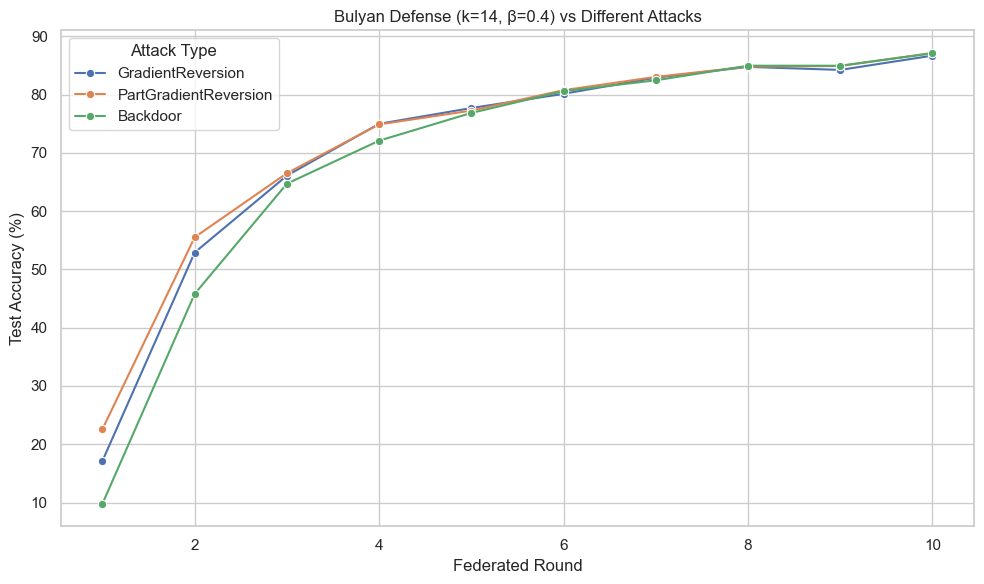

In [80]:
# plotting for the defauls parameters
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load your full results
df = pd.read_csv("bulyan_hyperparam_sweep.csv")

# Filter for the desired hyperparameters
df_filtered = df[(df["k"] == 14) & (df["beta"] == 0.4)]

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x="Round", y="Test accuracy", hue="attack", marker="o")

plt.title("Bulyan Defense (k=14, β=0.4) vs Different Attacks")
plt.xlabel("Federated Round")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(title="Attack Type")
plt.tight_layout()
plt.show()


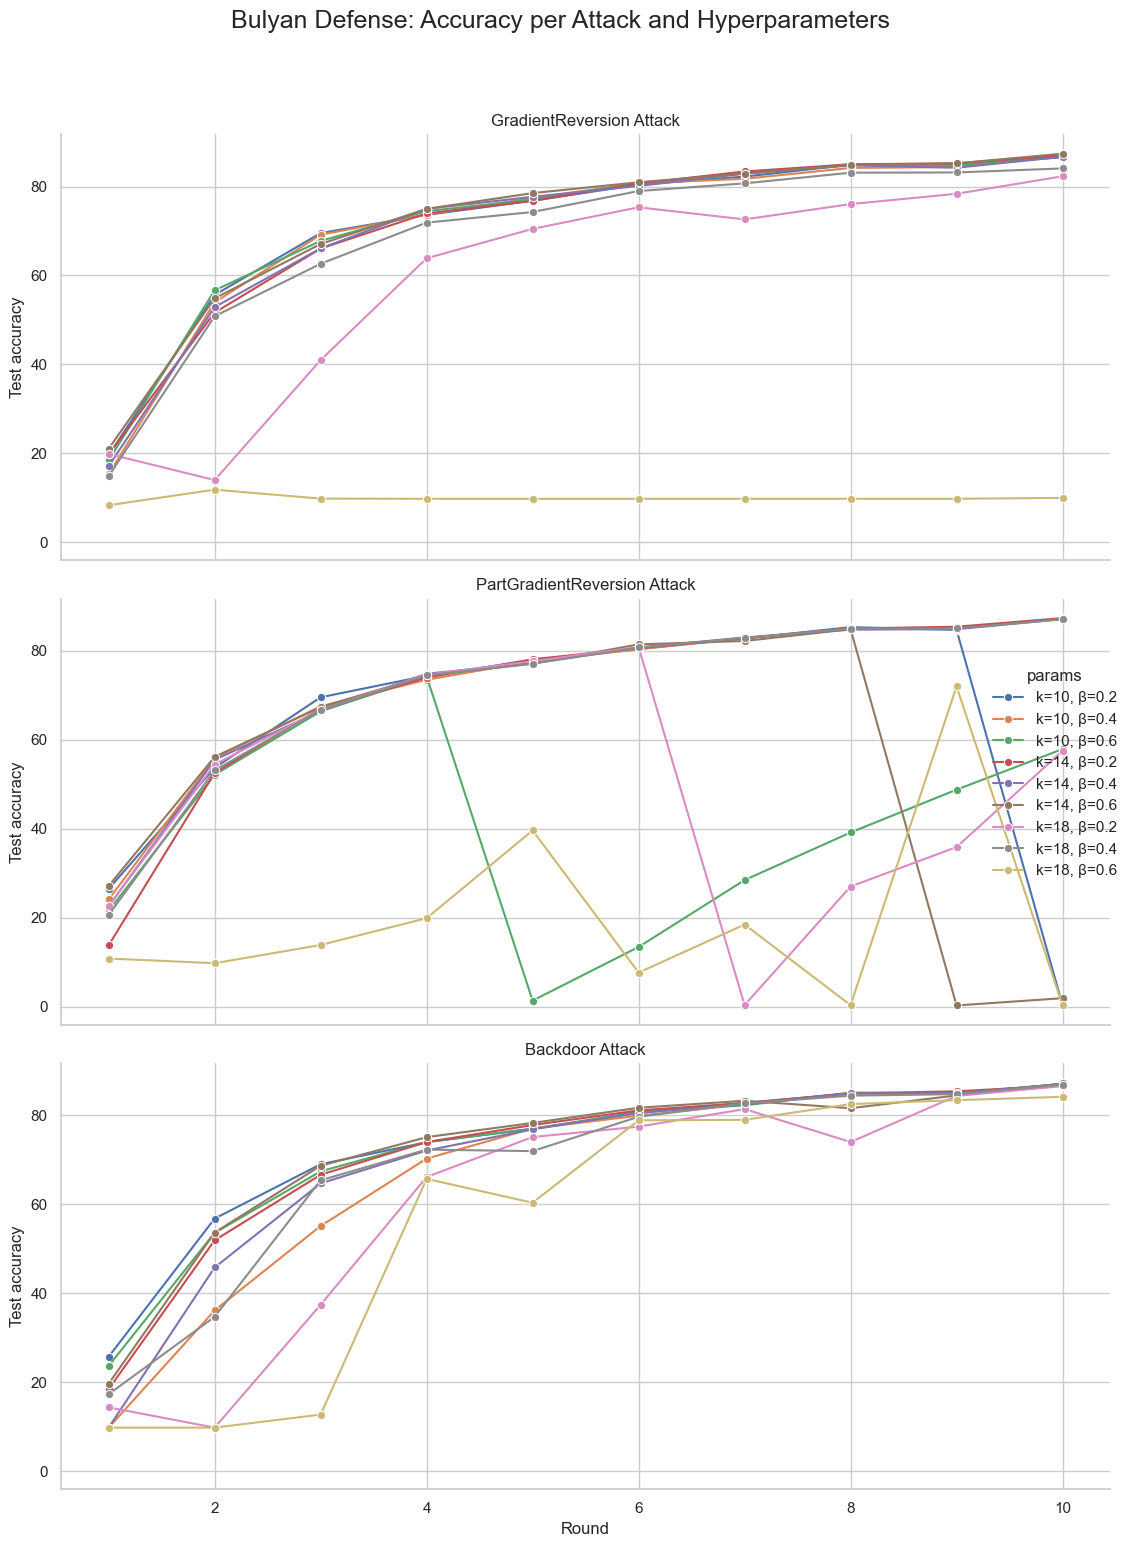

In [83]:
g = sns.FacetGrid(
    df,
    col="attack",
    hue="params",
    col_wrap=1,      # single column layout
    height=5,        # tall plots
    aspect=2,        # wide plots
    sharey=True
)

g.map(sns.lineplot, "Round", "Test accuracy", marker="o").add_legend()
g.set_titles("{col_name} Attack")
g.fig.suptitle("Bulyan Defense: Accuracy per Attack and Hyperparameters", fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

In the evaluation of the Bulyan defense across three different attack types—Gradient Reversion, Partial Gradient Reversion, and Backdoor—we observe distinct patterns in how the choice of hyperparameters k (number of selected clients via multi-krum) and β (proportion of trimmed extremes in trimmed-mean) affects the model’s robustness.

For the Gradient Reversion attack, Bulyan proves to be highly effective, with most configurations showing steady increases in accuracy across rounds. In particular, combinations like (k=14, β=0.4) and (k=18, β=0.4) maintain strong, consistent performance above 85% accuracy. However, overly aggressive trimming, such as using a high β (e.g., β=0.6) with high k, degrades performance drastically, suggesting that the model is discarding too many useful updates along with malicious ones. Overall, moderate values of both hyperparameters result in stable and effective defense.

When facing the Partial Gradient Reversion attack, the defense becomes more sensitive to the choice of parameters. Although Bulyan still manages to preserve high accuracy with settings like (k=14, β=0.2) or (k=10, β=0.4), other configurations, particularly those with k=18 and β=0.6, exhibit erratic behavior and frequent drops in accuracy—even reaching near-zero in some rounds. This indicates that partial attacks are harder to detect, and trimming too aggressively can backfire, especially if the gradients from honest clients are mistakenly discarded.

In contrast, under the Backdoor attack, Bulyan shows robust and stable performance across nearly all parameter settings. The accuracy climbs rapidly and sustains above 80–85%, even for higher β values. This suggests that the spatially localized and label-targeted nature of backdoor gradients makes them easier to isolate through the defense mechanisms. Notably, (k=14, β=0.4) and (k=14, β=0.6) emerge as particularly strong choices, combining resilience with generalization.

In summary, Bulyan is most reliable when k is set around 14 and β is kept moderate (around 0.2–0.4). This balance ensures that enough clients contribute to the update while preventing over-pruning. The defense performs best against backdoor attacks, maintains solid performance against full gradient reversions, and is somewhat more vulnerable to partial gradient manipulations if hyperparameters are not carefully chosen.

## Question 3: Implementing SparseFed Defense (7 points)

In this exercise, you will implement the [SparseFed Defense](https://arxiv.org/abs/2112.06274). SparseFed Defense involves two main steps for each participating device during the training process:
1. **Clipping the gradient:** Each device clips its gradient to reduce the impact of potentially malicious updates.
2. **Aggregating top-k updates:** During the aggregation phase, only the gradients with the highest magnitudes (top-k) are considered. This method is designed to minimize the risk of model poisoning by excluding anomalous gradient contributions from potentially compromised devices.

### Scoring:
- _(2 points)_ Implement a simplified version of SparseFed based on the clipping code provided in the template notebook. Unlike the original algorithm which includes momentum, you only need to implement the clipping step and the sparsification step. However, ensure that only the top-k coordinates in the aggregated gradients are selected based on their magnitudes. For example, if the aggregated gradient is `[3, -1, -1, -3]`, selecting the top-2 by magnitude should result in `[3, 0, 0, -3]`.

- _(3 points)_ Evaluate the performance of your implemented SparseFed defense against two types of attacks: `AttackerGradientReversion` and `AttackerBackdoor`. Adjust the values of the defense hyperparameter k to optimize defense effectiveness. Ensure the data distribution remains i.i.d., and the attacker's hyperparameters are unchanged from the template. Document and compare the performance of SparseFed to the simple clipping defense across these attack scenarios. Suggested values for k include percentages of the total parameters, such as 20%, 50%, and 80%.

- _(2 points)_ Analyze and discuss the results to determine if SparseFed provided any improvements. Explain why the sparsefication either succeeded or failed in enhancing the model's robustness against the specified attacks. Include this analysis in your notebook.
